In [1]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ------ Import necessary packages ----
#from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite


#matplotlib.use("agg")


import numpy as np
import scipy as sp
import math
import random
from cmath import exp #so that exp(a*I) works
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

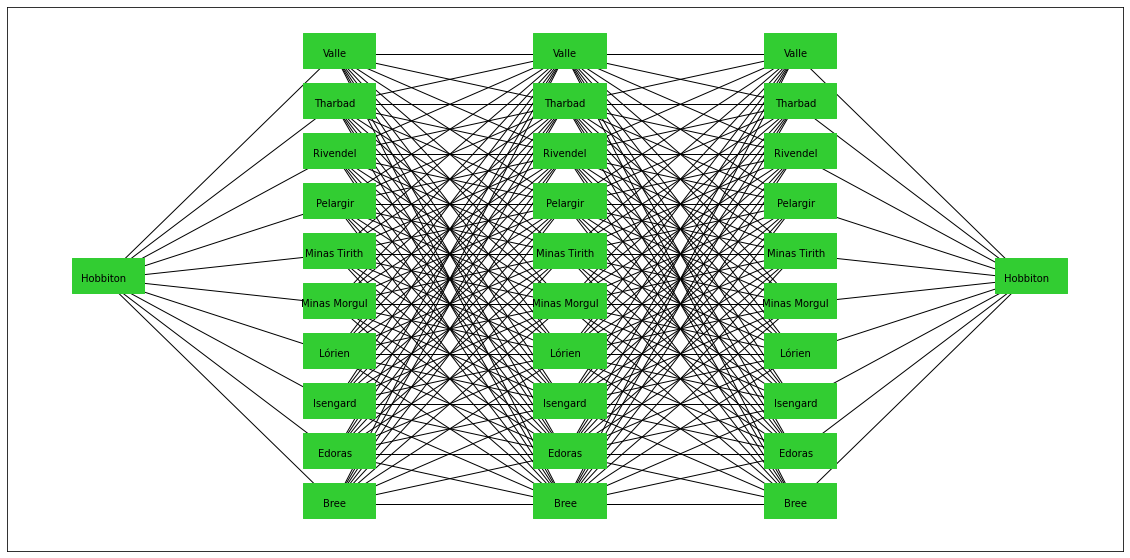

In [22]:
# ------- Set up our graph -------

# Create empty graph
G = nx.Graph()

places=("Bree", "Edoras", "Isengard", "Hobbiton", "Lórien", "Minas Morgul", "Minas Tirith", "Pelargir", "Rivendel", "Tharbad", "Valle")
pos = {} #position of nodes

pMAX=3 #max number of steps

home="Hobbiton"


G.add_node((home,0)) #starting point
pos.update({(home,0):(0,len(places))}) #to draw home in a centered point

for p in range(1, pMAX+1): #intermediate steps
    y=0 #y position of the nodes in the picture
    for i in range(len(places)):
        if places[i]!=home:
            y=y+2
            G.add_node((places[i],p))
            pos.update({(places[i],p):(2*(p),y)}) #ordering the places for each timestep
G.add_node((home,pMAX+1)) #end point
pos.update({(home,pMAX+1):(2*(pMAX+1),len(places))})

        
        
#V = np.arange(0,n,1) #the vector [0 1 2 3 ... n-1] 




#BUILDING THE DISTANCE DICTIONARY
distance_matrix=np.array([[0,200,150,40,140,290,285,315,100,67,225],[0,0,48,225,100,122,102,117,172,133,235],[0,0,0,175,83,165,150,163,135,83,225],[0,0,0,0,183,327,321,342,167,90,270],[0,0,0,0,0,162,158,192,77,100,145],[0,0,0,0,0,0,15,54,215,240,240],[0,0,0,0,0,0,0,432,200,229,245],[0,0,0,0,0,0,0,0,243,252,290],[0,0,0,0,0,0,0,0,0,100,125],[0,0,0,0,0,0,0,0,0,0,220],[0,0,0,0,0,0,0,0,0,0,0]])#in leagues
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
        distance_matrix[j,i]=distance_matrix[i,j]
        
distance_dictionary={}#in leagues
for i in range(len(places)):
    for j in range(len(places)):
        distance_dictionary.update({(places[i],places[j]):distance_matrix[i,j]})

#print(distance_dictionary)



#ADDING THE WEIGHTED EDGES
Edg = []

for node1 in G:
    for node2 in G:
        if node1[1]-node2[1]==1:#if they are one temporal step appart
            #print((node1,node2,distance_dictionary[(node1[0],node2[0])]))
            #print("")
            Edg.append((node1,node2,distance_dictionary[(node1[0],node2[0])]))



        
G.add_weighted_edges_from(Edg)

colors = ['limegreen' for node in G.nodes()] #cyan 

node_labels={}
for key in G:
    node_labels[key]=key[0] #change the labels of the nodes from ("place", p) to "place"

plt.figure(1,figsize=(20,10)) 
nx.draw_networkx(G,pos, node_size=6500, node_shape="$▬$", font_size=10, labels=node_labels, node_color=colors)
plt.show()

In [47]:

#elem in G.edges has the shape (('Hobbiton', 0), ('Bree', 1))

v=2 #moving speed. used to convert interplace distances into travel times.


Q = {}
for node1 in G.nodes:
    for node2 in G.nodes:
        Q.update({(node1,node2):0})

#ADDING THE TIME SPENT MOVING TO ANOTHER PLACE
#if the xi, xj conection is active, we sum the distance we have travelled
#synonim: if xj=1 then E+=Dij => Qjj+=Dij
for node1, node2 in G.edges: #node_i has the shape (place,p)
    Q.update({(node1,node2):Q[(node1,node2)]+distance_dictionary[node1[0],node2[0]]/v}) #moving requires time and doing a new job
    #in Q we distinguish between xip and xiq, but neither of w, priority or distance_dictionary care about p
    #hence Q[(node1,node2)] only depends on node1[0] node2[0]
    #remember that node1 and node2 have a ("place", p) structure
    
#ADDING THE CONSTRAINT THAT WE HAVE TO "TOUCH" HOME (l1)
l1=400 #how strongly do we want to be at home
for node in G.nodes:
    if node[0]==home:
        Q.update({(node,node):Q[(node,node)]-l1})

    
    
#NOW, ADDING THE CONSTRAINT THAT EACH PLACE IS 1-VISITABLE, EXCEPT HOME(l2)
#We add a term l(x0p+...+xNp-1)^2=2lSUM_ij(xip xjp)-l
l2=100
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1[0]==node2[0] and node1[0]!=home: #if they are the same place but not home
            if node1[1]!=node2[1]: #but they are in a different timestep:
                Q.update({(node1,node2):Q[(node1,node2)]+l2})    
    
    
#NOW, ADDING THE CONSTRAINT THAT EACH TIME IS 1-VISITABLE (l3)
#We add a term l(x0p+...+xNp-1)^2=2lSUM_ij(xip xjp)-l
l3=200
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1[1]==node2[1]: #if they are in the same timestep
            if node1[0]!=node2[0]: #but they are a different place:
                Q.update({(node1,node2):Q[(node1,node2)]+l3}) 
                

#NOW, ADDING THE CONSTRAINT THAT exactly pMAX+2 NODES HAVE TO BE VISITED (l2)
#Sum(xip)=pMAX+2
#We add a term l(xi1+...+xipMAX-(pMAX+2))^2=-(pMAX+1)lSUM_ip(xip)+2lSUM_ijpq(xip xjq)-l
l4=1
for node1 in G.nodes:
    for node2 in G.nodes:
        Q.update({(node1,node1):Q[(node1,node1)]-(pMAX+1)*l4})
        Q.update({(node1,node2):Q[(node1,node2)]+2*l4}) 

            
print(Q)
    

{(('Hobbiton', 0), ('Hobbiton', 0)): -526, (('Hobbiton', 0), ('Bree', 1)): 22.0, (('Hobbiton', 0), ('Edoras', 1)): 114.5, (('Hobbiton', 0), ('Isengard', 1)): 89.5, (('Hobbiton', 0), ('Lórien', 1)): 93.5, (('Hobbiton', 0), ('Minas Morgul', 1)): 165.5, (('Hobbiton', 0), ('Minas Tirith', 1)): 162.5, (('Hobbiton', 0), ('Pelargir', 1)): 173.0, (('Hobbiton', 0), ('Rivendel', 1)): 85.5, (('Hobbiton', 0), ('Tharbad', 1)): 47.0, (('Hobbiton', 0), ('Valle', 1)): 137.0, (('Hobbiton', 0), ('Bree', 2)): 2, (('Hobbiton', 0), ('Edoras', 2)): 2, (('Hobbiton', 0), ('Isengard', 2)): 2, (('Hobbiton', 0), ('Lórien', 2)): 2, (('Hobbiton', 0), ('Minas Morgul', 2)): 2, (('Hobbiton', 0), ('Minas Tirith', 2)): 2, (('Hobbiton', 0), ('Pelargir', 2)): 2, (('Hobbiton', 0), ('Rivendel', 2)): 2, (('Hobbiton', 0), ('Tharbad', 2)): 2, (('Hobbiton', 0), ('Valle', 2)): 2, (('Hobbiton', 0), ('Bree', 3)): 2, (('Hobbiton', 0), ('Edoras', 3)): 2, (('Hobbiton', 0), ('Isengard', 3)): 2, (('Hobbiton', 0), ('Lórien', 3)): 2, ((

In [48]:
# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 400
numruns = 100

# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,chain_strength=chainstrength,num_reads=numruns,label='Example - Maximum Cut')

print(response)

# ------- Print results to user -------
print('-' * 120)
print('{:>15s}{:^105s}'.format('Energy','Set 1',))
print('-' * 120)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>70s}'.format(str(E),str(S1)))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.first.sample


   ('Bree', 1) ('Bree', 2) ('Bree', 3) ... ('Valle', 3)  energy num_oc. ...
0            1           0           0 ...            0 -1225.0       1 ...
95           0           0           1 ...            0 -1210.0       1 ...
30           0           0           1 ...            0 -1208.5       1 ...
1            0           0           1 ...            0 -1185.0       1 ...
39           0           0           1 ...            0 -1178.0       1 ...
61           0           0           1 ...            0 -1176.5       1 ...
2            0           0           0 ...            0 -1170.5       1 ...
71           0           0           0 ...            0 -1170.5       1 ...
52           1           0           0 ...            0 -1168.5       1 ...
3            1           0           0 ...            0 -1162.0       2 ...
4            0           0           1 ...            0 -1158.5       1 ...
5            0           0           0 ...            0 -1158.0       1 ...
6           

In [ ]:
# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

filename = "TSP_LOTR.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))

In [124]:
distance_matrix=np.array([[0,200,150,40,140,290,285,315,100,67,225],[0,0,48,225,100,122,102,117,172,133,235],[0,0,0,175,83,165,150,163,135,83,225],[0,0,0,0,183,327,321,342,167,90,270],[0,0,0,0,0,162,158,192,77,100,145],[0,0,0,0,0,0,15,54,215,240,240],[0,0,0,0,0,0,0,432,200,229,245],[0,0,0,0,0,0,0,0,243,252,290],[0,0,0,0,0,0,0,0,0,100,125],[0,0,0,0,0,0,0,0,0,0,220],[0,0,0,0,0,0,0,0,0,0,0]])#in leagues

#distance_matrix=((0,200,150,40,140,290,285,315,100,67,225),(0,0,48,225,100,122,102,117,172,133,235),(0,0,0,175,83,165,150,163,135,83,225),(0,0,0,0,183,327,321,342,167,90,270),(0,0,0,0,0,162,158,192,77,100,145),(0,0,0,0,0,0,15,54,215,240,240), (0,0,0,0,0,0,0,432,200,229,245),(0,0,0,0,0,0,0,0,243,252,290),(0,0,0,0,0,0,0,0,0,100,125),(0,0,0,0,0,0,0,0,0,0,220),(0,0,0,0,0,0,0,0,0,0,0))#in leagues
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
        distance_matrix[j,i]=distance_matrix[i,j]
    
print(distance_matrix)

[[  0 200 150  40 140 290 285 315 100  67 225]
 [200   0  48 225 100 122 102 117 172 133 235]
 [150  48   0 175  83 165 150 163 135  83 225]
 [ 40 225 175   0 183 327 321 342 167  90 270]
 [140 100  83 183   0 162 158 192  77 100 145]
 [290 122 165 327 162   0  15  54 215 240 240]
 [285 102 150 321 158  15   0 432 200 229 245]
 [315 117 163 342 192  54 432   0 243 252 290]
 [100 172 135 167  77 215 200 243   0 100 125]
 [ 67 133  83  90 100 240 229 252 100   0 220]
 [225 235 225 270 145 240 245 290 125 220   0]]


In [67]:
for node1, node2 in G.edges:
    print(node1, node2)

('Hobbiton', 0) ('Bree', 1)
('Hobbiton', 0) ('Edoras', 1)
('Hobbiton', 0) ('Isengard', 1)
('Hobbiton', 0) ('Lórien', 1)
('Hobbiton', 0) ('Minas Morgul', 1)
('Hobbiton', 0) ('Minas Tirith', 1)
('Hobbiton', 0) ('Pelargir', 1)
('Hobbiton', 0) ('Rivendel', 1)
('Hobbiton', 0) ('Tharbad', 1)
('Hobbiton', 0) ('Valle', 1)
('Bree', 1) ('Bree', 2)
('Bree', 1) ('Edoras', 2)
('Bree', 1) ('Isengard', 2)
('Bree', 1) ('Lórien', 2)
('Bree', 1) ('Minas Morgul', 2)
('Bree', 1) ('Minas Tirith', 2)
('Bree', 1) ('Pelargir', 2)
('Bree', 1) ('Rivendel', 2)
('Bree', 1) ('Tharbad', 2)
('Bree', 1) ('Valle', 2)
('Edoras', 1) ('Bree', 2)
('Edoras', 1) ('Edoras', 2)
('Edoras', 1) ('Isengard', 2)
('Edoras', 1) ('Lórien', 2)
('Edoras', 1) ('Minas Morgul', 2)
('Edoras', 1) ('Minas Tirith', 2)
('Edoras', 1) ('Pelargir', 2)
('Edoras', 1) ('Rivendel', 2)
('Edoras', 1) ('Tharbad', 2)
('Edoras', 1) ('Valle', 2)
('Isengard', 1) ('Bree', 2)
('Isengard', 1) ('Edoras', 2)
('Isengard', 1) ('Isengard', 2)
('Isengard', 1) ('Lóri

In [6]:
l1=20
for node1, node2 in G.edges:
    print("node1[0]=",node1[0])
    print("node2[0]=",node2[0])
    if node1[0]==node2[0]: #if they are the same place in different times
        print("match!")
        Q.update({(node1,node2):Q[(node1,node2)]+2*l1})
    print("")

node1[0]= Hobbiton
node2[0]= Bree

node1[0]= Hobbiton
node2[0]= Edoras

node1[0]= Hobbiton
node2[0]= Isengard

node1[0]= Hobbiton
node2[0]= Lórien

node1[0]= Hobbiton
node2[0]= Minas Morgul

node1[0]= Hobbiton
node2[0]= Minas Tirith

node1[0]= Hobbiton
node2[0]= Pelargir

node1[0]= Hobbiton
node2[0]= Rivendel

node1[0]= Hobbiton
node2[0]= Tharbad

node1[0]= Hobbiton
node2[0]= Valle

node1[0]= Bree
node2[0]= Bree
match!


NameError: name 'Q' is not defined